In [35]:
import numpy as np
import pickle
import itertools
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchvision import transforms
from SegDataset import SegmentationDataset
from einops import rearrange
from transformers import AdamW, SegformerForSemanticSegmentation
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.data import DataLoader

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Config

In [37]:
DATASET_DIRECTORY = "ml-mangrove-data/"
#PRETRAINED_MODEL_NAME = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024" #alternative pretrained_model_name = "nvidia/mit-b5"
PRETRAINED_MODEL_NAME ="./segformer-b5-finetuned-mangrove-128-128/" 


DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #device to be used for training and evaluation
PIN_MEMORY = True if DEVICE == "cuda" else False #if we will be pinning memory during data loading

INPUT_IMAGE_WIDTH = 128 #or 256
INPUT_IMAGE_HEIGHT = 128
NUM_CHANNELS = 9
NUM_CLASSES = 1

TEST_SPLIT = 0.10
BATCH_SIZE = 32
INIT_LR = 0.0001 #0.0001 #0.00006
NUM_EPOCHS = 10
TEST_EVAL_EVERY_BATCH = 15 #how frequently to compute/save/display test accuracy, must be non-zero positive

EARLY_STOPPER_PATIENCE = 2 #how many epochs of lower test set accuracy before early stopping (also dependent on delta)
EARLY_STOPPER_DELTA = 0 #how much test set accuracy needs to drop before early stopping (also dependent on patience)

# THRESHOLD = 0.5 # define threshold to filter weak predictions
# BASE_OUTPUT = "output" # define the path to the base output directory

# define the path to the output serialized model, model training
# plot, and testing image paths
# MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_mangrove.pth")
# PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
# TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

Read Files

In [38]:
#read data from https://www.kaggle.com/datasets/stanleydil/e4e-jamaica-segmentation-dataset by read from kaggle
with open(DATASET_DIRECTORY + '128px_images.pkl', 'rb') as handle:
    images = pickle.load(handle)

with open(DATASET_DIRECTORY + '128px_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

with open(DATASET_DIRECTORY + '128_mlabels.pkl', 'rb') as handle:
    m_tiles = pickle.load(handle)

Data Preprocessing

In [39]:
#rearrange dimensions of images and labels
images = np.array(images)
images = rearrange(images, "b w h c -> b c w h")

labels = np.array(labels)
labels = rearrange(labels, "b w h c -> b c w h")
labels = np.squeeze(labels, axis=1)

print(f'input shape (b x c x w x h): {images.shape}')
print(f'label shape (b x [squeezed 1 channel] x w x h): {labels.shape}')

input shape (b x c x w x h): (4092, 9, 128, 128)
label shape (b x [squeezed 1 channel] x w x h): (4092, 128, 128)


In [40]:
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
trainImages, testImages, trainMasks, testMasks = train_test_split(images, labels, #images, labels,
                         test_size=TEST_SPLIT, random_state=42)
# unpack the data split
# (trainImages, testImages) = split[:2]
# (trainMasks, testMasks) = split[2:]
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT,
                                                    INPUT_IMAGE_WIDTH)),
                                 transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks, transforms = transforms)
                              #transforms=transforms)
testDS = SegmentationDataset(images=testImages, labels=testMasks, transforms = transforms)
                             #transforms=transforms)
print(f"found {len(trainDS)} examples in the training set.")
print(f"found {len(testDS)} examples in the test set.")
# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=0) #os.cpu_count()
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=0) #os.cpu_count()

found 3682 examples in the training set.
found 410 examples in the test set.


In [41]:
# assign the human-readable labels to encoding, encoding to human-readable labels
id2label = {
    0: "nomangrove",
    1: "mangrove"
}

label2id = {
    "nomangrove": 0,
    "mangrove": 1
}

Initialize Model

In [42]:
# Load the pretrained model
model = SegformerForSemanticSegmentation.from_pretrained(
    PRETRAINED_MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_labels = 2
)

# Modify the first layer to match the number of channels in data
modified_layer = nn.Conv2d(NUM_CHANNELS, 64, kernel_size=7, stride=4, padding=3)
model.segformer.encoder.patch_embeddings[0].proj = modified_layer

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at ./segformer-b5-finetuned-mangrove-128-128/ and are newly initialized because the shapes did not match:
- segformer.encoder.patch_embeddings.0.proj.weight: found shape torch.Size([64, 9, 7, 7]) in the checkpoint and torch.Size([64, 3, 7, 7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(9, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [44]:
batch = next(iter(trainLoader))
test_batch = itertools.cycle(testLoader)

In [45]:
optimizer = AdamW(model.parameters(), lr=INIT_LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

/home/mpham/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model Initialized!


Train

In [46]:
class Early_stopper: #early stopper class -> move to py file
    def __init__(self):
        self.patience = EARLY_STOPPER_PATIENCE
        self.delta = EARLY_STOPPER_DELTA
        self.patience_counter = 0
        self.min_test_loss = np.inf
    def check_stop(self, test_loss):
        if self.min_test_loss > test_loss:
            self.patience_counter = 0
            self.min_test_loss = test_loss
        elif test_loss > (self.min_test_loss + self.delta):
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
        return False

In [47]:
class Total_updater:
  def __init__(self):
    self.test_epoch = [] 
    self.test_acc = [] 
    self.test_avr_acc = [] 
    self.test_loss = [] 
    self.test_avr_loss = [] 
    self.test_avr_acc_epoch = []
    self.test_avr_loss_epoch = []
    self.tests_count = 0 
    self.tests_epoch_count = 0 

    self.train_epoch = []
    self.train_acc = []
    self.train_avr_acc = []
    self.train_loss = []
    self.train_avr_loss = []
    self.train_avr_acc_epoch = []
    self.train_avr_loss_epoch = []
    self.trains_count = 0
    self.trains_epoch_count = 0


    self.epoch_test_acc_cum = 0 #use
    self.total_test_acc_cum = 0 #use
    self.epoch_test_loss_cum = 0 #use
    self.total_test_loss_cum = 0 #use

    self.epoch_train_acc_cum = 0
    self.total_train_acc_cum = 0
    self.epoch_train_loss_cum = 0
    self.total_train_loss_cum = 0

    self.epoch = 0
  def update_test(self, acc, loss):
    self.tests_count += 1
    self.tests_epoch_count += 1
    self.test_epoch.append(self.epoch + TEST_EVAL_EVERY_BATCH * self.tests_epoch_count/(len(trainDS) // BATCH_SIZE + 1 ))#self.epoch + (self.tests_epoch_count-1)/self.tests_epoch_count)

    self.test_acc.append(acc)
    self.test_acc.append(loss)

    self.epoch_test_acc_cum += acc
    self.total_test_acc_cum += acc
    self.epoch_test_loss_cum += loss
    self.total_test_loss_cum += loss

    self.test_avr_acc.append(self.total_test_acc_cum/self.tests_count)
    self.test_avr_loss.append(self.total_test_loss_cum/self.tests_count)

  def update_train(self, acc, loss):
    self.trains_count += 1
    self.trains_epoch_count += 1
    self.train_epoch.append(self.epoch + self.trains_epoch_count/(len(trainDS) // BATCH_SIZE + 1 )) #(self.epoch + (self.trains_epoch_count-1)/self.trains_epoch_count)

    self.train_acc.append(acc)
    self.train_acc.append(loss)

    self.epoch_train_acc_cum += acc
    self.total_train_acc_cum += acc
    self.epoch_train_loss_cum += loss
    self.total_train_loss_cum += loss

    self.train_avr_acc.append(self.total_train_acc_cum/self.trains_count)
    self.train_avr_loss.append(self.total_train_loss_cum/self.trains_count)


  def reset_epoch(self):
    self.test_avr_acc_epoch.append(self.epoch_test_acc_cum/self.tests_epoch_count)
    self.test_avr_loss_epoch.append(self.epoch_test_loss_cum/self.tests_epoch_count)

    self.train_avr_acc_epoch.append(self.epoch_train_acc_cum/self.trains_epoch_count)
    self.train_avr_loss_epoch.append(self.epoch_train_loss_cum/self.trains_epoch_count)
    
    print(f"EPOCH {self.epoch} Avr Test Accuracy: {self.test_avr_acc_epoch[self.epoch]}\
         Avr Test Loss: {self.test_avr_loss_epoch[self.epoch]}\
         Avr Train Accuracy: {self.train_avr_acc_epoch[self.epoch]}\
         Avr Train Loss: {self.train_avr_loss_epoch[self.epoch]}")
    
    
    self.epoch_test_acc_cum = 0
    self.epoch_test_loss_cum = 0
    self.epoch_train_acc_cum = 0
    self.epoch_train_loss_cum = 0

    self.tests_epoch_count = 0
    self.trains_epoch_count = 0

    self.epoch += 1



In [48]:
# accuracies = []
# losses = []
# test_accuracies = []
# test_losses = []
# batch_index = 0
early_stopper = Early_stopper()
total_updater = Total_updater()

In [49]:
for epoch in range(NUM_EPOCHS):
    print("Epoch:", epoch)
    pbar = tqdm(trainLoader)
    model.train()
    
    total_train_set = []
    for idx, batch in enumerate(pbar):
        batch_index = idx

        # get the inputs
        pixel_values = batch[0].to(device)
        labels = batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        #train set eval
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        mask = (labels != -1) # don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss

        total_updater.update_train(accuracy, loss.item())

        # accuracies.append(accuracy)
        # losses.append(loss.item())

        pbar.set_postfix({'Batch': idx, 'Batch Train Accuracy': accuracy, 'Train Loss': loss.item()})

        #test set eval
        if idx//TEST_EVAL_EVERY_BATCH == idx/TEST_EVAL_EVERY_BATCH:
            model.eval()
            next_test_batch = next(test_batch)
            test_pixel_values = next_test_batch[0].to(device)
            test_labels = next_test_batch[1].to(device)
            test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
            test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
            test_predicted = test_upsampled_logits.argmax(dim=1)
            test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
            test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
            test_true_labels = test_labels[test_mask].detach().cpu().numpy()
            test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
            test_loss = test_outputs.loss

            total_updater.update_test(test_accuracy, test_loss.item())
            
            print(f'Batch Test Accuracy: {test_accuracy}, Test Loss: {test_loss.item()}')
            model.train()


        # backward + optimize
        loss.backward()
        optimizer.step()

    total_updater.reset_epoch()

    #early stopping
    test_loss_epoch = total_updater.test_avr_loss_epoch[total_updater.epoch-1]
    if early_stopper.check_stop(test_loss_epoch):             
        break

Epoch: 0


  0%|          | 0/116 [00:14<?, ?it/s, Batch=0, Batch Train Accuracy=0.879, Train Loss=0.789]

Batch Test Accuracy: 0.9138736724853516, Test Loss: 1.09552800655365


 14%|█▍        | 16/116 [01:28<09:08,  5.48s/it, Batch=15, Batch Train Accuracy=0.915, Train Loss=0.133]

Batch Test Accuracy: 0.9013442993164062, Test Loss: 0.18566109240055084


 26%|██▌       | 30/116 [02:27<05:26,  3.80s/it, Batch=30, Batch Train Accuracy=0.924, Train Loss=0.127]

Batch Test Accuracy: 0.9131031036376953, Test Loss: 0.1402079463005066


 40%|███▉      | 46/116 [03:42<05:57,  5.11s/it, Batch=45, Batch Train Accuracy=0.886, Train Loss=0.204] 

Batch Test Accuracy: 0.9319400787353516, Test Loss: 0.10591036081314087


 52%|█████▏    | 60/116 [04:42<03:19,  3.56s/it, Batch=60, Batch Train Accuracy=0.928, Train Loss=0.153] 

Batch Test Accuracy: 0.9234905242919922, Test Loss: 0.15690012276172638


 66%|██████▌   | 76/116 [05:41<03:07,  4.68s/it, Batch=75, Batch Train Accuracy=0.932, Train Loss=0.128] 

Batch Test Accuracy: 0.9143562316894531, Test Loss: 0.14012230932712555


Train/Test Loss/Accuracy Plot

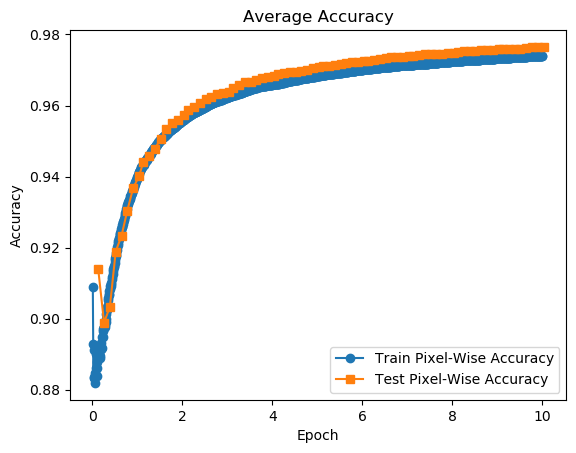

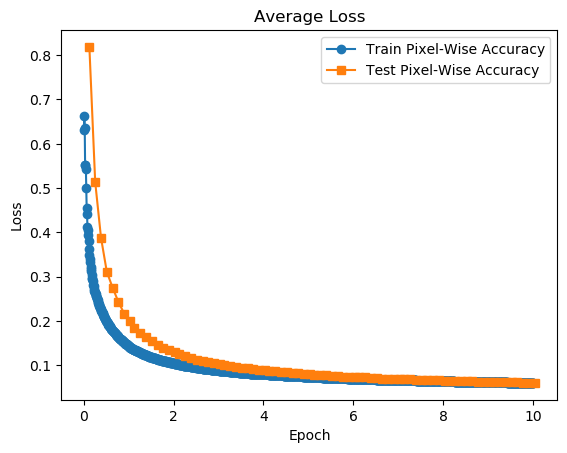

In [ ]:
plt.plot(total_updater.train_epoch, total_updater.train_avr_acc, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_acc, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy')

plt.legend()
plt.show()


plt.plot(total_updater.train_epoch, total_updater.train_avr_loss, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_loss, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss')

plt.legend()
plt.show()

In [ ]:
total_updater.test_avr_acc_epoch

[0.9400343894958496,
 0.974431221301739,
 0.9773390293121338,
 0.9816789810474102,
 0.9814055332770715,
 0.9807260036468506,
 0.9820765898777888,
 0.981442928314209,
 0.9838183843172513,
 0.98160353073707]

Hugging Face Upload

In [ ]:
# model.save_pretrained("segformer-b5-finetuned-mangrove-128-128") #save weights to folder

In [ ]:
# model.save_model("./my_model")

# with open('auth_token.txt', 'r') as file:
#     auth_token = file.read().strip()

# model.save_model("mpham8/segformer-b5-finetuned-mangrove-128-128", use_auth_token=auth_token)